In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
#pip install sodapy

Note: you may need to restart the kernel to use updated packages.


In [134]:
#pip install census

Note: you may need to restart the kernel to use updated packages.


In [135]:
import download
import mlpipeline
import helper

In [136]:
eviction = download.load_evict('../inputs/eviction_data_tract.csv')
crime = download.load_crime('../inputs/crime_by_tract.csv')
buildings = download.load_building('../inputs/building_violation_by_tract.csv')
acs = download.load_acs('../inputs/acs_year_tract.csv')
education = download.load_education('../inputs/educ_year_tract.csv')
tracts = download.load_tract('../inputs/ch_opdat/tracts.csv')

In [137]:
tracts.columns

Index(['tract', 'commarea'], dtype='object')

In [138]:
eviction_df = download.join_bases(eviction, acs, education, crime, buildings, tracts)

In [139]:
eviction_df.shape

(6375, 284)

In [140]:
eviction_df.shape

(6375, 284)

In [141]:
helper.explore_data(eviction_df)

Let's take a look at the first 10 lines of the dataframe!

  filing_year   tract  eviction_filings_total  eviction_filings_rate  \
0  2010-01-01  010100                     119                   5.99   
1  2010-01-01  010201                      82                   4.66   
2  2010-01-01  010202                      58                   6.45   
3  2010-01-01  010300                      78                   3.96   
4  2010-01-01  010400                      42                   2.82   
5  2010-01-01  010501                      59                   2.94   
6  2010-01-01  010502                      38                   2.57   
7  2010-01-01  010503                       7                   0.72   
8  2010-01-01  010600                      68                   3.48   
9  2010-01-01  010701                      35                   4.56   

   eviction_filings_completed  case_type_single_action  \
0                         116                       14   
1                          77   

       eviction_filings_total  eviction_filings_rate  \
count             6375.000000            6375.000000   
mean                29.408784               4.118163   
std                 32.559917               3.223992   
min                  0.000000               0.000000   
25%                  9.000000               1.740000   
50%                 19.000000               3.390000   
75%                 37.000000               5.970000   
max                346.000000              39.290000   

       eviction_filings_completed  case_type_single_action  \
count                 6375.000000              6375.000000   
mean                    26.520784                 4.770824   
std                     30.822073                 5.857236   
min                      0.000000                 0.000000   
25%                      8.000000                 1.000000   
50%                     17.000000                 3.000000   
75%                     34.000000                 6.000000   

In [142]:
print(eviction_df['filing_year'].min())
print(eviction_df['filing_year'].max())

2010-01-01 00:00:00
2017-01-01 00:00:00


In [99]:
eviction_df.loc[(eviction_df['year'] == 2011) & (eviction_df['tract'] == '010100'), 'eviction_filings_rate']

12    6.79
Name: eviction_filings_rate, dtype: float64

In [143]:
eviction_df = mlpipeline.create_label(eviction_df, 'year', 'eviction_filings_rate', .9, 12)

Index(['filing_year', 'tract', 'eviction_filings_total',
       'eviction_filings_rate', 'eviction_filings_completed',
       'case_type_single_action', 'case_type_joint_action', 'back_rent_median',
       'back_rent_0', 'back_rent_1_to_999',
       ...
       'total_department_bureau_SPECIAL TASK FORCE_mean_by_commarea',
       'total_department_bureau_VENTILATION_mean_by_commarea',
       'total_department_bureau_WATER_mean_by_commarea',
       'total_violation_status_COMPLIED_perc_mean_by_commarea',
       'total_violation_status_NO ENTRY_perc_mean_by_commarea',
       'total_violation_status_OPEN_perc_mean_by_commarea',
       'total_inspection_category_COMPLAINT_perc_mean_by_commarea',
       'perc_increase_bv_mean_by_commarea', 'next_year',
       'eviction_filings_rate_next_year'],
      dtype='object', length=286)
8.21
8.618
8.440000000000005
8.8
8.17
7.525
nan


In [144]:
eviction_df['label'].describe()

count    5564.000000
mean        0.086449
std         0.281051
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64

In [154]:
date_col = 'filing_year'
prediction_window = 12
start_time = '2010-01-01'
end_time = '2016-01-01'
len_train = 36
rv = mlpipeline.temporal_validation(eviction_df, date_col, prediction_window, start_time, end_time, len_train)

In [155]:
cols_to_discretize = ['case_type_single_action', 'case_type_joint_action', 'back_rent_median']
num_bins = 3
cats = ['low', 'medium', 'high']
cols_to_binary = []
for col in cols_to_discretize:
    cols_to_binary.append(col + "_group")
processed_rv = mlpipeline.process_train_data(rv, cols_to_discretize, 
                                            num_bins, cats, cols_to_binary)

perc_increase_total_crime_class_Violent Crime                             796
perc_increase_total_crime_class_Less serious offences_mean_by_commarea    795
perc_increase_bv                                                          795
perc_increase_bv_mean_by_commarea                                         795
perc_increase_total_crime_class_Property Crime                            795
perc_increase_total_crime_class_Less serious offences                     795
perc_increase_total_crime                                                 795
perc_increase_total_crime_class_Violent Crime_mean_by_commarea            795
perc_increase_total_crime_class_Property Crime_mean_by_commarea           795
perc_increase_total_crime_mean_by_commarea                                795
population_race_asian                                                       8
population_race_latinx                                                      8
population_poverty_above                                        

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/chinguyen/eviction-data-quality/scripts/mlpipeline.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  include_lowest=True)


housing_units_other                                               3
housing_units_rental                                              3
population_race_asian                                             3
population_race_latinx                                            3
population_race_black                                             3
population_race_white                                             3
population_poverty_above                                          3
population_poverty_below                                          3
population_race_other                                             3
total_primary_type_CONCEALED CARRY LICENSE VIOLATION              0
total_primary_type_PROSTITUTION                                   0
total_primary_type_OTHER OFFENSE                                  0
total_primary_type_PUBLIC INDECENCY                               0
total_primary_type_PUBLIC PEACE VIOLATION                         0
total_primary_type_ROBBERY                      

housing_units_other                                               2
housing_units_rental                                              2
population_race_asian                                             2
population_race_latinx                                            2
population_race_black                                             2
population_race_white                                             2
population_poverty_above                                          2
population_poverty_below                                          2
population_race_other                                             2
total_primary_type_CONCEALED CARRY LICENSE VIOLATION              0
total_primary_type_PROSTITUTION                                   0
total_primary_type_OTHER OFFENSE                                  0
total_primary_type_PUBLIC INDECENCY                               0
total_primary_type_PUBLIC PEACE VIOLATION                         0
total_primary_type_ROBBERY                      

population_race_other                                             2
population_race_asian                                             2
population_race_latinx                                            2
population_race_black                                             2
population_race_white                                             2
population_poverty_above                                          2
housing_units_rental                                              2
housing_units_other                                               2
population_poverty_below                                          2
perc_increase_total_crime_class_Violent Crime                     1
total_primary_type_OTHER OFFENSE                                  0
label                                                             0
total_primary_type_WEAPONS VIOLATION                              0
total_primary_type_PUBLIC INDECENCY                               0
total_primary_type_PUBLIC PEACE VIOLATION       

In [156]:
selected_features = ['case_type_single_action_group_low',
 'case_type_single_action_group_medium',
 'case_type_single_action_group_high',
 'case_type_single_action_group_nan',
 'case_type_joint_action_group_low',
 'case_type_joint_action_group_medium',
 'case_type_joint_action_group_high',
 'case_type_joint_action_group_nan',
 'back_rent_median_group_low',
 'back_rent_median_group_medium',
 'back_rent_median_group_high',
 'back_rent_median_group_nan']

In [157]:
len(selected_features)

12

In [158]:
grid_size = 'test'
clfs, grid = helper.define_clfs_params(grid_size)
models_to_run = ['DT']
predictors = selected_features
outcome = 'label'
thresholds = [1, 2, 5, 10, 20, 30, 50]
time_col = 'filing_year'

DT


<Figure size 432x288 with 0 Axes>

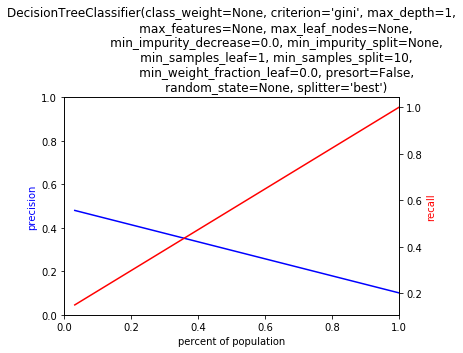

DT


<Figure size 432x288 with 0 Axes>

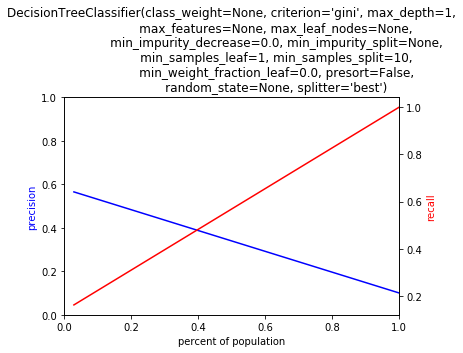

DT


<Figure size 432x288 with 0 Axes>

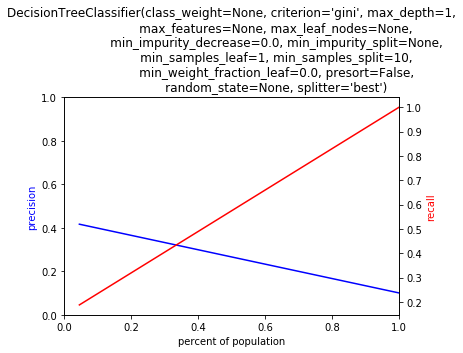

,model_type,clf,parameters,split_date,min_year_in_train,max_year_in_train,min_year_in_test,max_year_in_test,baseline,p_at_1,...,p_at_20,recall_at_20,f1_at_20,p_at_30,recall_at_30,f1_at_30,p_at_50,recall_at_50,f1_at_50,auc-roc
0,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...",2013-01-01,2010-01-01,2012-01-01,2013-01-01,2013-01-01,0.100756,0.142857,...,0.075949,0.1500,0.100840,0.142857,0.425,0.213836,0.201511,1.0,0.335430,0.565896
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...",2014-01-01,2010-01-01,2013-01-01,2014-01-01,2014-01-01,0.100503,0.285714,...,0.081761,0.1625,0.108787,0.142857,0.425,0.213836,0.201005,1.0,0.334728,0.574267
2,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...",2015-01-01,2010-01-01,2014-01-01,2015-01-01,2015-01-01,0.100503,0.142857,...,0.094340,0.1875,0.125523,0.142857,0.425,0.213836,0.201005,1.0,0.334728,0.579085


In [159]:
results_df = mlpipeline.clf_loop_cross_validation(models_to_run, clfs, grid, processed_rv, 
                                                    predictors, outcome, thresholds, time_col)
results_df

In [147]:
key1 = list(processed_rv.keys())[0]
train = processed_rv[key1][0]
l = list(train.columns)
l

['filing_year',
 'tract',
 'eviction_filings_total',
 'eviction_filings_rate',
 'eviction_filings_completed',
 'case_type_single_action',
 'case_type_joint_action',
 'back_rent_median',
 'back_rent_0',
 'back_rent_1_to_999',
 'back_rent_1000_to_2499',
 'back_rent_2500_to_4999',
 'back_rent_5000_or_more',
 'landlord_represented',
 'tenant_represented',
 'tenant_rep_pa',
 'tenant_rep_laa',
 'eviction_order_yes',
 'eviction_order_no',
 'eviction_order_yes_tenant_prose',
 'eviction_order_no_tenant_prose',
 'eviction_order_yes_tenant_represented',
 'eviction_order_no_tenant_represented',
 'eviction_order_yes_tenant_rep_pa',
 'eviction_order_no_tenant_rep_pa',
 'eviction_order_yes_tenant_rep_laa',
 'eviction_order_no_tenant_rep_laa',
 'ftu_eviction_order',
 'ftu_other_outcome',
 'ftu_no_outcome',
 'ftu_eviction_order_tenant_prose',
 'ftu_other_outcome_tenant_prose',
 'ftu_no_outcome_tenant_prose',
 'ftu_eviction_order_tenant_represented',
 'ftu_other_outcome_tenant_represented',
 'ftu_no_out

In [148]:
train['label'].describe()

count    2382.000000
mean        0.101175
std         0.301624
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: label, dtype: float64